In [1]:
import matplotlib.pyplot as plt

%matplotlib notebook

In [5]:
import numpy as np
import fitsio
import esutil
import glob
import tqdm
import joblib

In [6]:
import random

fnames = glob.glob("outputs/DES*.fits")
random.shuffle(fnames)

n_tiles = 100

jobs = []
for fname in tqdm.tqdm(fnames[0:n_tiles]):
    jobs.append(joblib.delayed(fitsio.read)(fname))
with joblib.Parallel(n_jobs=4, backend='loky', verbose=100) as exc:
    ds = exc(jobs)

d = esutil.numpy_util.combine_arrlist(ds)

100%|██████████| 100/100 [00:00<00:00, 96265.87it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Do

In [10]:
msk = (
    (d["flags"] == 0) 
    & (d["mdet_flags"] == 0) 
    & (d["mdet_s2n"] > 5) 
    & (d["mdet_T_ratio"] > 1.2)
    & (d["mfrac"] < 0.1)
)

In [11]:
gmsk = (
    (np.sqrt(np.prod(d["mdet_g"]**2, axis=1)) < 1)
    & np.all(np.abs(d["mdet_g"]) < 1, axis=1)
)

print("frac passes cuts                :", np.mean(msk))
print("total passes cuts               :", np.sum(msk))
print("total passes cuts and shear cuts:", np.sum(msk & gmsk))
print("frac diff:", 1.0 - np.sum(msk & gmsk) / np.sum(msk))

frac passes cuts                : 0.37953723639732423
total passes cuts               : 16653629
total passes cuts and shear cuts: 16653450
frac diff: 1.0748408049710001e-05


<IPython.core.display.Javascript object>


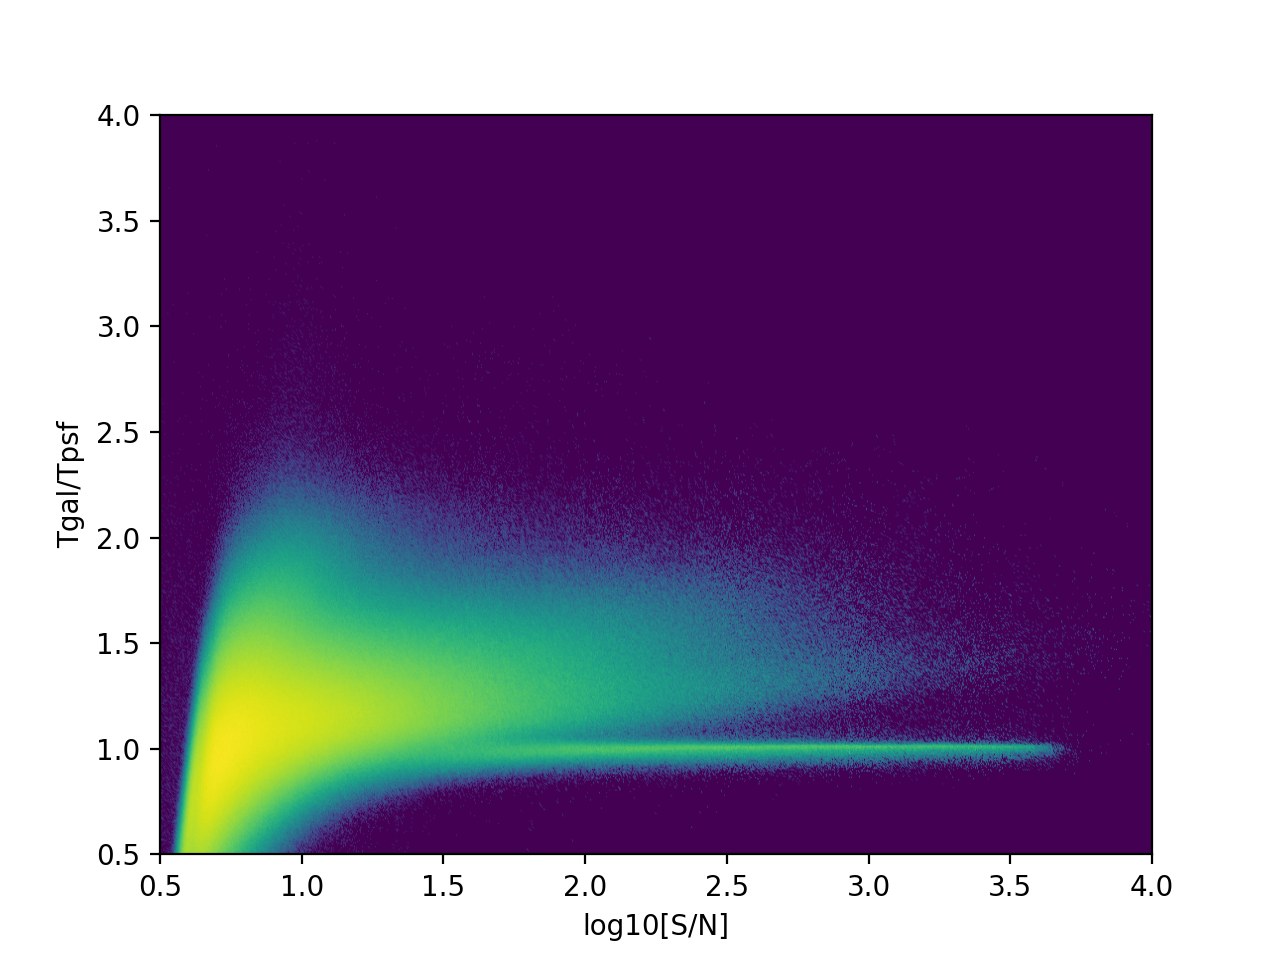

Text(0, 0.5, 'Tgal/Tpsf')

In [15]:
pmsk = (
    (d["flags"] == 0) 
    & (d["mdet_flags"] == 0) 
    & (d["mdet_s2n"] > 1) 
    & (d["mdet_T_ratio"] > 0.5)
    & (d["mfrac"] < 0.1)
)

plt.figure()
plt.hexbin(
    np.log10(d["mdet_s2n"][pmsk]), 
    d["mdet_T_ratio"][pmsk], 
    bins='log',
    gridsize=1000,
    extent=(0.5, 4, 0.5, 4),
)
ax = plt.gca()
ax.set_xlim(0.5, 4)
ax.set_ylim(0.5, 4)

ax.set_xlabel("log10[S/N]")
ax.set_ylabel("Tgal/Tpsf")

<IPython.core.display.Javascript object>


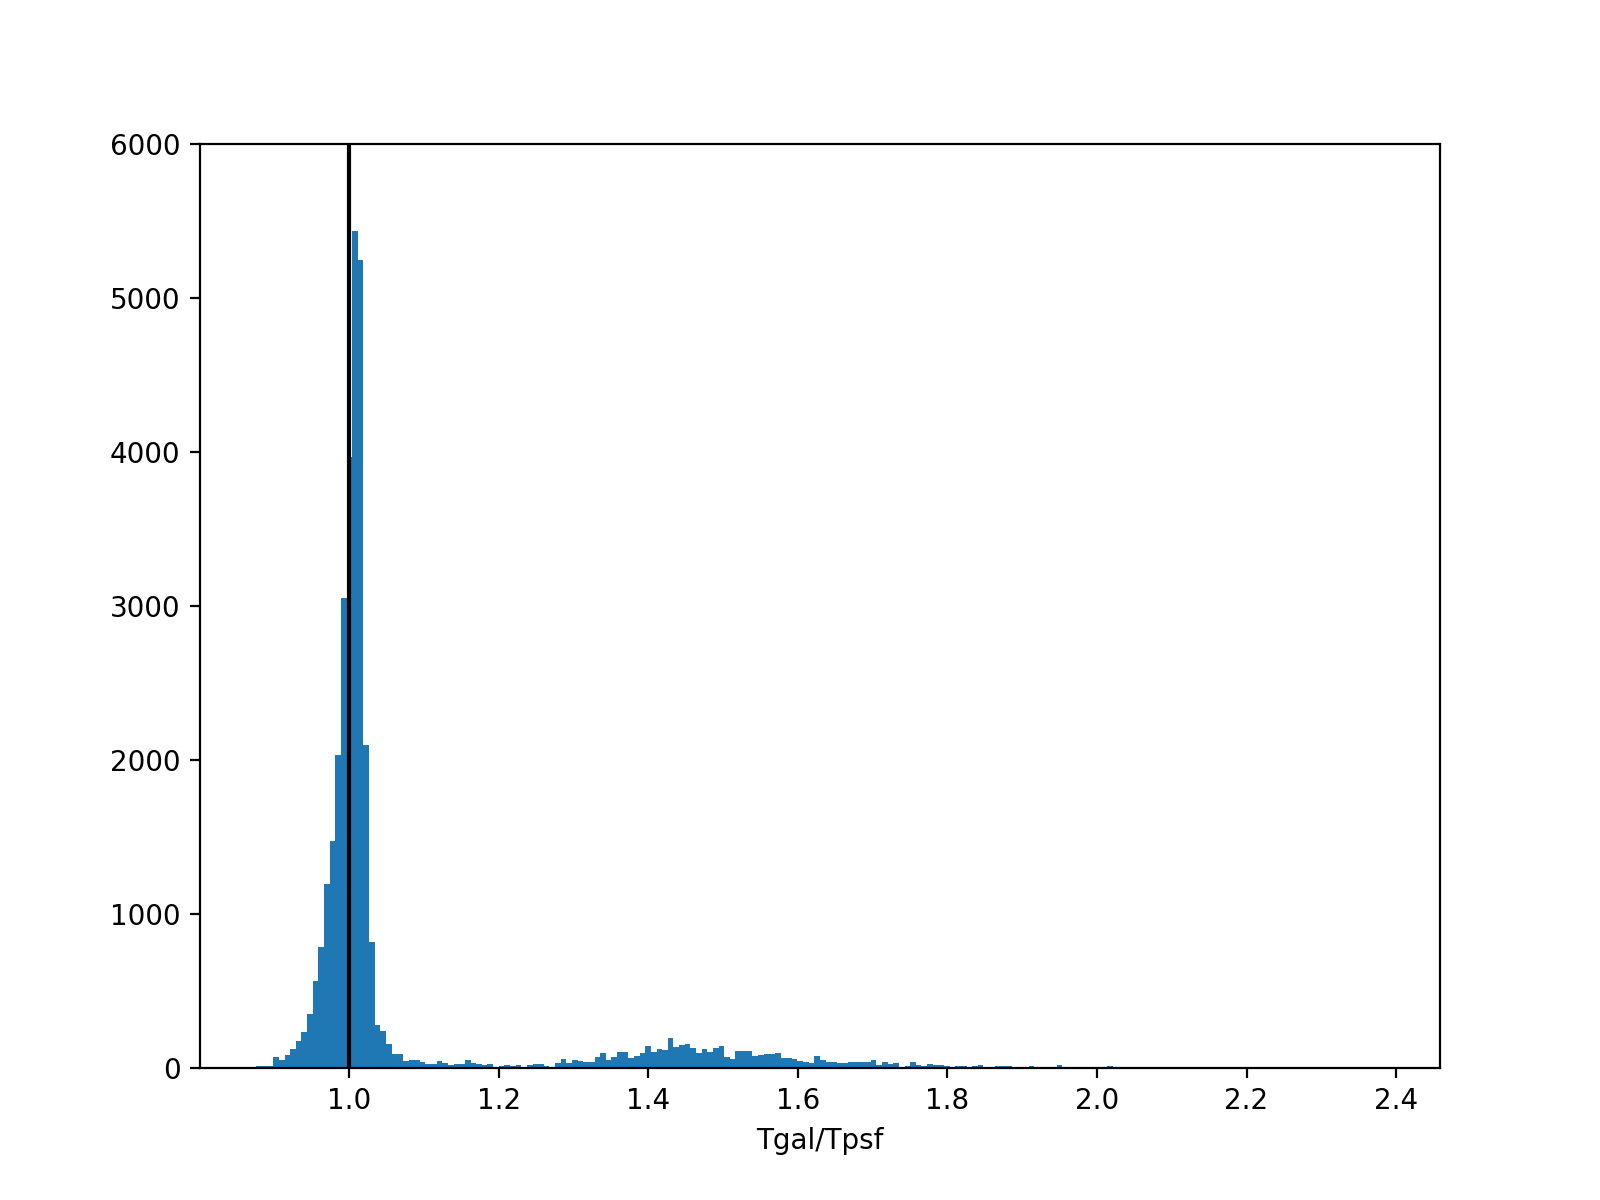

(0.0, 6000.0)

In [25]:
pmsk = (
    (d["flags"] == 0) 
    & (d["mdet_flags"] == 0) 
    & (d["mdet_s2n"] > np.power(10, 3.5)) 
    & (d["mdet_T_ratio"] > 0.5)
    & (d["mfrac"] < 0.1)
)

plt.figure(figsize=(8, 6))
plt.hist(d["mdet_T_ratio"][pmsk], bins=200)
ax = plt.gca()
ax.set_xlabel("Tgal/Tpsf")
ax.vlines(1, 0, 6000, color='k')
ax.set_ylim(0, 6000)